In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import pickle

In [2]:

DATA_FILENAME = "/kaggle/input/life-data/life_expectancy_data.csv"
input_size=5
output_size=1

In [3]:
 
dataframe = pd.read_csv(DATA_FILENAME)

dataframe.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


## Cleaning the data
Some cell names have trailing spaces or are composed of two separate names, I am gonna fix that and impose a more consistent naming scheme

In [4]:
# Renaming some column names as they contain trailing spaces.
dataframe.rename(columns={" BMI ":"BMI","Life expectancy ":"Life_Expectancy","Adult Mortality":"Adult_Mortality",
                   "infant deaths":"Infant_Deaths","percentage expenditure":"Percentage_Exp","Hepatitis B":"HepatitisB",
                  "Measles ":"Measles"," BMI ":"BMI","under-five deaths ":"Under_Five_Deaths","Diphtheria ":"Diphtheria",
                  " HIV/AIDS":"HIV/AIDS"," thinness  1-19 years":"thinness_1to19_years"," thinness 5-9 years":"thinness_5to9_years","Income composition of resources":"Income_Comp_Of_Resources",
                   "Total expenditure":"Tot_Exp"},inplace=True)
dataframe.head()

,Country,Year,Status,Life_Expectancy,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Exp,HepatitisB,Measles,...,Polio,Tot_Exp,Diphtheria,HIV/AIDS,GDP,Population,thinness_1to19_years,thinness_5to9_years,Income_Comp_Of_Resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [5]:
# Verifying whether data for each variable is according to its dataype or not.
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   2938 non-null   object 
 1   Year                      2938 non-null   int64  
 2   Status                    2938 non-null   object 
 3   Life_Expectancy           2928 non-null   float64
 4   Adult_Mortality           2928 non-null   float64
 5   Infant_Deaths             2938 non-null   int64  
 6   Alcohol                   2744 non-null   float64
 7   Percentage_Exp            2938 non-null   float64
 8   HepatitisB                2385 non-null   float64
 9   Measles                   2938 non-null   int64  
 10  BMI                       2904 non-null   float64
 11  Under_Five_Deaths         2938 non-null   int64  
 12  Polio                     2919 non-null   float64
 13  Tot_Exp                   2712 non-null   float64
 14  Diphther

In [6]:
# Identify percentage of null values in each column.
dataframe.isnull().sum()*100/dataframe.isnull().count()

Country                      0.000000
Year                         0.000000
Status                       0.000000
Life_Expectancy              0.340368
Adult_Mortality              0.340368
Infant_Deaths                0.000000
Alcohol                      6.603131
Percentage_Exp               0.000000
HepatitisB                  18.822328
Measles                      0.000000
BMI                          1.157250
Under_Five_Deaths            0.000000
Polio                        0.646698
Tot_Exp                      7.692308
Diphtheria                   0.646698
HIV/AIDS                     0.000000
GDP                         15.248468
Population                  22.191967
thinness_1to19_years         1.157250
thinness_5to9_years          1.157250
Income_Comp_Of_Resources     5.684139
Schooling                    5.547992
dtype: float64

In [7]:
# save the countries in a list
country_list = dataframe.Country.unique()

# list containing incomplete columns
fill_list = ['Life_Expectancy','Adult_Mortality','Alcohol','HepatitisB','BMI','Polio','Tot_Exp','Diphtheria','GDP','Population','thinness_1to19_years','thinness_5to9_years','Income_Comp_Of_Resources','Schooling']

In [8]:
# Treat null values using interpolation.
for country in country_list:
    dataframe.loc[dataframe['Country'] == country,fill_list] = dataframe.loc[dataframe['Country'] == country,fill_list].interpolate()
    
# Drop remaining null values after interpolation.
dataframe.dropna(inplace=True)

In [9]:
# Verifying null-values after applying above methods.
dataframe.isnull().sum()

Country                     0
Year                        0
Status                      0
Life_Expectancy             0
Adult_Mortality             0
Infant_Deaths               0
Alcohol                     0
Percentage_Exp              0
HepatitisB                  0
Measles                     0
BMI                         0
Under_Five_Deaths           0
Polio                       0
Tot_Exp                     0
Diphtheria                  0
HIV/AIDS                    0
GDP                         0
Population                  0
thinness_1to19_years        0
thinness_5to9_years         0
Income_Comp_Of_Resources    0
Schooling                   0
dtype: int64

## Data analysis
We are gonna look for relevant correlations to decide which columns we will use to train our model<br>
Let's start with some general statistics about our data

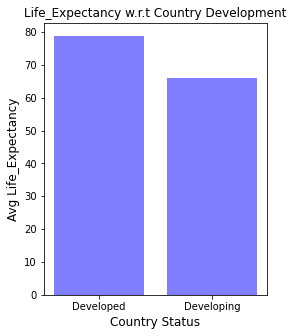

In [10]:
# Life_Expectancy w.r.t Year using bar plot.
plt.figure(figsize=(4,5))
plt.bar(dataframe.groupby('Status')['Status'].count().index,dataframe.groupby('Status')['Life_Expectancy'].mean(),color='blue',alpha=0.50)
plt.xlabel("Country Status",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy w.r.t Country Development")
plt.show()

In [11]:
round(dataframe[['Status','Life_Expectancy']].groupby(['Status']).mean(),2)

,Life_Expectancy
Status,
Developed,78.83
Developing,66.16


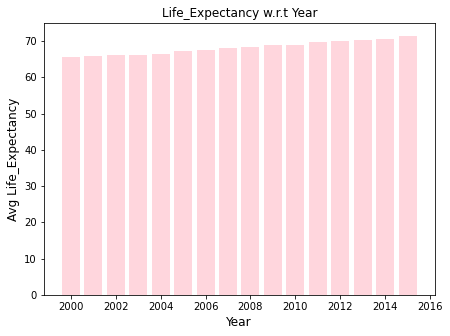

In [12]:
# Life_Expectancy w.r.t Year using bar plot.
plt.figure(figsize=(7,5))
plt.bar(dataframe.groupby('Year')['Year'].count().index,dataframe.groupby('Year')['Life_Expectancy'].mean(),color='pink',alpha=0.65)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy w.r.t Year")
plt.show()

So there is a definite difference between developed countries and the rest, but at least the life expectancy improves every year.
Now let's try to figure out wich features affect life expectancy the most.

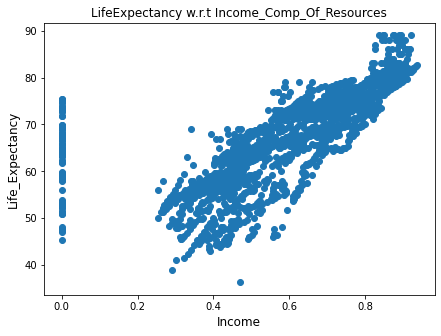

In [13]:
plt.figure(figsize=(7,5))
plt.title("LifeExpectancy w.r.t Income_Comp_Of_Resources")
plt.xlabel("Income",fontsize=12)
plt.ylabel("Life_Expectancy",fontsize=12)
plt.scatter(dataframe["Income_Comp_Of_Resources"], dataframe["Life_Expectancy"])

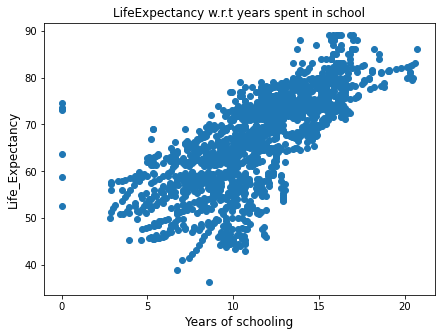

In [14]:
plt.figure(figsize=(7,5))
plt.title("LifeExpectancy w.r.t years spent in school")
plt.xlabel("Years of schooling",fontsize=12)
plt.ylabel("Life_Expectancy",fontsize=12)
plt.scatter(dataframe["Schooling"], dataframe["Life_Expectancy"])

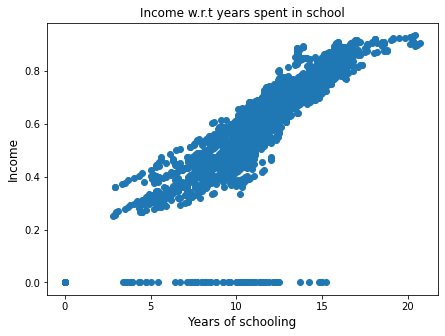

In [15]:
plt.figure(figsize=(7,5))
plt.title("Income w.r.t years spent in school")
plt.xlabel("Years of schooling",fontsize=12)
plt.ylabel("Income",fontsize=12)
plt.scatter(dataframe["Schooling"], dataframe["Income_Comp_Of_Resources"])

We can infer that schooling and income composition are positively correlated between themselves and with life expectancy

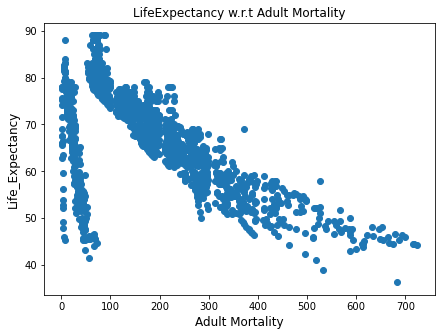

In [16]:
plt.figure(figsize=(7,5))
plt.title("LifeExpectancy w.r.t Adult Mortality")
plt.xlabel("Adult Mortality",fontsize=12)
plt.ylabel("Life_Expectancy",fontsize=12)
plt.scatter(dataframe["Adult_Mortality"], dataframe["Life_Expectancy"])

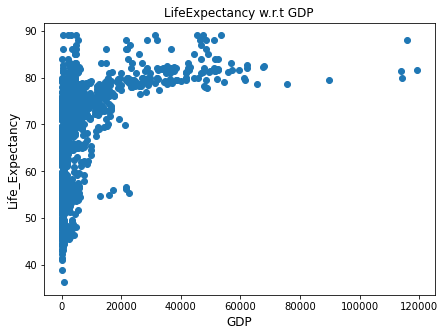

In [17]:
plt.figure(figsize=(7,5))
plt.title("LifeExpectancy w.r.t GDP")
plt.xlabel("GDP",fontsize=12)
plt.ylabel("Life_Expectancy",fontsize=12)
plt.scatter(dataframe["GDP"], dataframe["Life_Expectancy"])

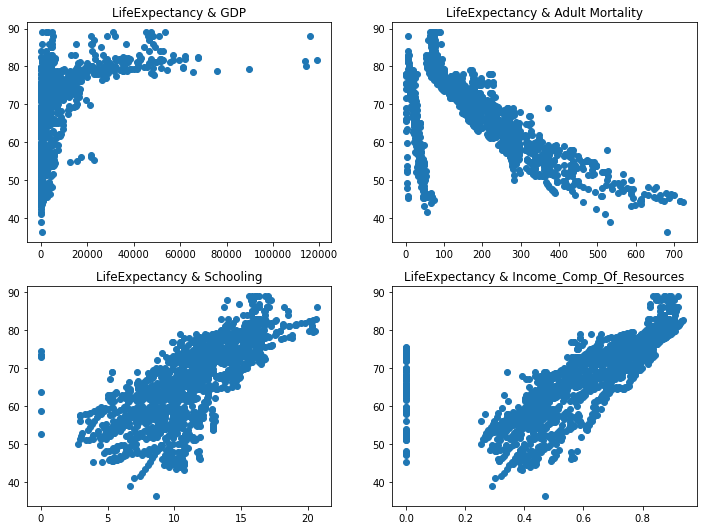

In [18]:
plt.figure(figsize=(12, 38))

plt.subplot(8,2,1)
plt.title("LifeExpectancy & GDP")
plt.scatter(dataframe["GDP"], dataframe["Life_Expectancy"])

plt.subplot(8,2,2)
plt.title("LifeExpectancy & Adult Mortality")
plt.scatter(dataframe["Adult_Mortality"], dataframe["Life_Expectancy"])

plt.subplot(8,2,3)
plt.title("LifeExpectancy & Schooling")
plt.scatter(dataframe["Schooling"], dataframe["Life_Expectancy"])

plt.subplot(8,2,4)
plt.title("LifeExpectancy & Income_Comp_Of_Resources")
plt.scatter(dataframe["Income_Comp_Of_Resources"], dataframe["Life_Expectancy"])

The four features shown above plus the status of the country will be used for building the machine learning model

## Data loaders
Now I will prepare the designated column into the data that will be used in the ml model

In [19]:
# label the designated data
num_rows = dataframe.index.size
categorical_cols = ['Status']
TARGET_COLUMN = ['Life_Expectancy']
inputs = ['Status', 'GDP', 'Adult_Mortality', 'Schooling', 'Income_Comp_Of_Resources']
dataframe[inputs].head()

,Status,GDP,Adult_Mortality,Schooling,Income_Comp_Of_Resources
0,Developing,584.259210,263.0,10.1,0.479
1,Developing,612.696514,271.0,10.0,0.476
2,Developing,631.744976,268.0,9.9,0.470
3,Developing,669.959000,272.0,9.8,0.463
4,Developing,63.537231,275.0,9.5,0.454


In [20]:
# Convert from Pandas dataframe to numpy arrays
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[inputs].to_numpy()
    targets_array = dataframe1[TARGET_COLUMN].to_numpy()
    return inputs_array, targets_array

In [21]:
inputs, targets = dataframe_to_arrays(dataframe)
inputs, targets

(array([[1.00000000e+00, 5.84259210e+02, 2.63000000e+02, 1.01000000e+01,
         4.79000000e-01],
        [1.00000000e+00, 6.12696514e+02, 2.71000000e+02, 1.00000000e+01,
         4.76000000e-01],
        [1.00000000e+00, 6.31744976e+02, 2.68000000e+02, 9.90000000e+00,
         4.70000000e-01],
        ...,
        [1.00000000e+00, 5.73483400e+01, 7.30000000e+01, 1.00000000e+01,
         4.27000000e-01],
        [1.00000000e+00, 5.48587312e+02, 6.86000000e+02, 9.80000000e+00,
         4.27000000e-01],
        [1.00000000e+00, 5.47358878e+02, 6.65000000e+02, 9.80000000e+00,
         4.34000000e-01]]),
 array([[65. ],
        [59.9],
        [59.9],
        ...,
        [44.8],
        [45.3],
        [46. ]]))

In [22]:
inputs.shape, targets.shape

((1987, 5), (1987, 1))

In [23]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))

val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size=2**9
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

## Model

In [24]:
class LifeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.l1_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.l1_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 50th epoch
        if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

## Training

In [25]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[1.0000e+00, 9.8924e+02, 3.6500e+02, 6.7000e+00, 3.7000e-01],
        [1.0000e+00, 4.4372e+03, 8.8000e+01, 1.3300e+01, 7.3800e-01],
        [1.0000e+00, 2.2325e+03, 2.2100e+02, 1.1000e+01, 0.0000e+00],
        ...,
        [1.0000e+00, 8.3796e+02, 2.5100e+02, 1.0000e+01, 4.5800e-01],
        [1.0000e+00, 1.8677e+02, 2.7100e+02, 1.0400e+01, 5.4200e-01],
        [1.0000e+00, 3.9881e+03, 1.5000e+01, 1.2300e+01, 6.7500e-01]])
targets: tensor([[51.6000],
        [76.6000],
        [67.9000],
        [71.9000],
        [65.4000],
        [71.9000],
        [72.8000],
        [71.6000],
        [71.2000],
        [67.5000],
        [65.0000],
        [76.3000],
        [63.0000],
        [79.0000],
        [62.3000],
        [61.6000],
        [71.8000],
        [55.4000],
        [67.3000],
        [64.7000],
        [79.8000],
        [46.8000],
        [55.6000],
        [67.1000],
        [67.9000],
        [73.7000],
        [75.5000],
        [74.7000],
        [74.4000]

In [26]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [27]:
model = LifeModel()

In [28]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3478, -0.3828, -0.4245, -0.0229,  0.0515]], requires_grad=True),
 Parameter containing:
 tensor([-0.0363], requires_grad=True)]

In [29]:
result = evaluate(model, val_loader)
result

{'val_loss': 2350.347900390625}

Now that the model has been initialized we can start the training

In [30]:
epochs = 10
learning_rate=1e-4
history = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [10], val_loss: 2326.5212


In [31]:
epochs = 1000
learning_rate=1e-4
history1 = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [50], val_loss: 2208.2668
Epoch [100], val_loss: 2089.5432
Epoch [150], val_loss: 1970.4994
Epoch [200], val_loss: 1851.7743
Epoch [250], val_loss: 1732.7101
Epoch [300], val_loss: 1614.1147
Epoch [350], val_loss: 1495.3931
Epoch [400], val_loss: 1377.7780
Epoch [450], val_loss: 1259.2814
Epoch [500], val_loss: 1140.4751
Epoch [550], val_loss: 1021.8945
Epoch [600], val_loss: 902.9029
Epoch [650], val_loss: 784.2167
Epoch [700], val_loss: 666.0102
Epoch [750], val_loss: 547.7524
Epoch [800], val_loss: 428.4262
Epoch [850], val_loss: 310.1703
Epoch [900], val_loss: 191.6537
Epoch [950], val_loss: 73.5954
Epoch [1000], val_loss: 57.3318


In [32]:
epochs = 1000
learning_rate=5e-3
history2 = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [50], val_loss: 28.3117
Epoch [100], val_loss: 20.5593
Epoch [150], val_loss: 15.5361
Epoch [200], val_loss: 10.4868
Epoch [250], val_loss: 8.6595
Epoch [300], val_loss: 8.7689
Epoch [350], val_loss: 8.2664
Epoch [400], val_loss: 9.2213
Epoch [450], val_loss: 8.1584
Epoch [500], val_loss: 10.0427
Epoch [550], val_loss: 7.7191
Epoch [600], val_loss: 7.8631
Epoch [650], val_loss: 7.5060
Epoch [700], val_loss: 7.4393
Epoch [750], val_loss: 8.1673
Epoch [800], val_loss: 8.3380
Epoch [850], val_loss: 7.2141
Epoch [900], val_loss: 7.4834
Epoch [950], val_loss: 7.2079
Epoch [1000], val_loss: 8.1768


In [33]:
epochs = 100
learning_rate=1e-5
history3 = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [50], val_loss: 7.0002
Epoch [100], val_loss: 7.0084


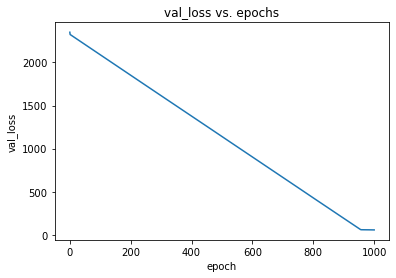

In [34]:
losses = [r['val_loss'] for r in [result] + history1]
plt.plot(losses, '-')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

Predictions

In [35]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [36]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([1.0000e+00, 7.3628e+03, 4.2800e+02, 1.2800e+01, 6.3000e-01])
Target:  58.0
Prediction: 71.51249694824219


In [37]:
x, target = val_ds[17]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([1.0000e+00, 9.2724e+03, 1.7800e+02, 1.2700e+01, 7.0800e-01])
Target:  71.30000305175781
Prediction: 73.24434661865234


In [38]:
x, target = val_ds[23]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([1.0000e+00, 2.7629e+03, 1.2000e+01, 1.3600e+01, 7.3600e-01])
Target:  73.0
Prediction: 78.17166137695312


In [39]:
# final parameters
list(model.parameters())

[Parameter containing:
 tensor([[ 1.0072e+01, -1.0498e-05, -6.8700e-03,  3.9601e+00,  5.5180e+00]],
        requires_grad=True),
 Parameter containing:
 tensor([10.2929], requires_grad=True)]

In [40]:
# # save the model to disk
# filename = 'linear_regression.pkl'
# pickle.dump(model, open(filename, 'wb'))